# Ordinal regression with the ImproperUniform distribution

Some data are discrete but instrinsically **ordered**, these are called [**ordinal**](https://en.wikipedia.org/wiki/Ordinal_data) data. One example is the [likert scale](https://en.wikipedia.org/wiki/Likert_scale) for questionairs ("this is an informative tutorial": 1. strongly disagree / 2. disagree / 3. neither agree nor disagree / 4. agree / 5. strongly agree). Ordinal data is also ubiquitous in the medical world (e.g. the [Glasgow Coma Scale](https://en.wikipedia.org/wiki/Glasgow_Coma_Scale) for measuring neurological disfunctioning). 

This poses a challenge for statistical modeling as the data do not fit the most well known modelling approaches (e.g. linear regression). Modeling the data as [categorical](https://en.wikipedia.org/wiki/Categorical_distribution) is one possibility, but it disregards the inherent ordering in the data, and may be less statistically efficient. There are multiple appoaches for modeling ordered data. Here we will show how to use the OrderedLogistic distribution using cutpoints that are sampled from a Normal distribution with as additional constrain that the cutpoints they are ordered. For a more in-depth discussion of Bayesian modeling of ordinal data, see e.g. [Michael Betancour's blog](https://betanalpha.github.io/assets/case_studies/ordinal_regression.html)

In [1]:
from jax import numpy as np, random
import numpyro
from numpyro import sample
from numpyro.distributions import constraints, Normal, ImproperUniform, Categorical, OrderedLogistic
from numpyro.infer.mcmc import MCMC
from numpyro.infer.hmc import NUTS
import pandas as pd
import seaborn as sns

First, generate data some with ordinal structure

In [2]:
simkeys  = random.split(random.PRNGKey(1), 2)
nsim     = 50
nclasses = 3
Y        = Categorical(logits=np.zeros(nclasses)).sample(simkeys[0], sample_shape=(nsim,))
X        = Normal().sample(simkeys[1], sample_shape = (nsim,))
X       += Y

print("value counts of Y:")
df = pd.DataFrame({'X': X, 'Y': Y})
print(df.Y.value_counts())

for i in range(nclasses):
    print(f"mean(X) for Y == {i}: {X[np.where(Y==i)].mean():.3f}")

value counts of Y:
1    19
2    16
0    15
Name: Y, dtype: int64
mean(X) for Y == 0: 0.042
mean(X) for Y == 1: 0.832
mean(X) for Y == 2: 1.448


<AxesSubplot:xlabel='Y', ylabel='X'>

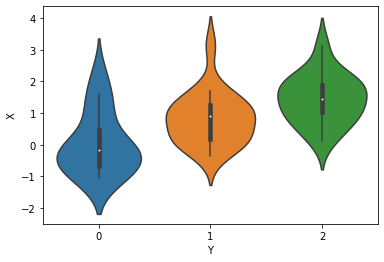

In [3]:
sns.violinplot(x='Y', y='X', data=df)

We will model the outcomes Y as coming from an OrderedLogistic distribution, conditional on X. The `OrderedLogistic` distribution in numpyro requires ordered cutpoints. We can use the `ImproperUnifrom` distribution to introduce a parameter with an arbitrary support that is otherwise completely uninformative, and then add an `ordered_vector` constraint.

In [4]:
def model1(X, Y, nclasses=3):
    b_X_eta = sample('b_X_eta', Normal(0, 5))
    c_y     = sample('c_y',     ImproperUniform(support=constraints.ordered_vector,
                                                batch_shape=(),
                                                event_shape=(nclasses-1,)))
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model1)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 341.47it/s, 7 steps of size 4.34e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.43      0.35      1.42      0.82      1.96    352.72      1.00
    c_y[0]     -0.11      0.41     -0.11     -0.78      0.55    505.85      1.00
    c_y[1]      2.18      0.52      2.15      1.35      2.95    415.22      1.00

Number of divergences: 0


If we have additional information on the parameters that we want to encode in a prior, we can add a `sample` statement that uses a 'regular' prior with an `obs` argument, conditioning the parameter drawn from the `ImproperUniform` on the chosen prior

In [5]:
def model2(X, Y, nclasses=3):
    b_X_eta = sample('b_X_eta', Normal(0, 5))    
    c_y     = sample('c_y',     ImproperUniform(support=constraints.ordered_vector,
                                                batch_shape=(),
                                                event_shape=(nclasses-1,)))
    sample('c_y_smp', Normal(0,1), obs=c_y)
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

kernel = NUTS(model2)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 373.91it/s, 7 steps of size 4.80e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.23      0.30      1.23      0.69      1.65    535.41      1.00
    c_y[0]     -0.25      0.33     -0.25     -0.82      0.27    461.96      1.00
    c_y[1]      1.76      0.38      1.75      1.10      2.33    588.10      1.00

Number of divergences: 0
